## 3.1 MNIST

In [2]:
import sklearn
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import numpy as np
 
for i in [mpl, np, sklearn]:
    print(i.__name__,": ",i.__version__)

matplotlib :  2.1.0
numpy :  1.19.5
sklearn :  0.22


In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


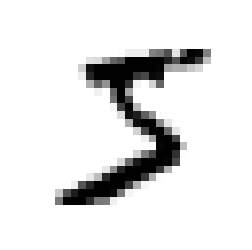

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 选取一张图片
some_digit = X[0]
# 图片特征向量 1x784 → 数组 28x28
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
# 标签输出为字符
y[0]

'5'

In [7]:
# 标签转化为数字
y = y.astype(np.uint8)
y[0]

5

In [8]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


for i in (X_train, X_test, y_train, y_test):
    print(i.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


## 3.2 训练二元分类器

In [9]:
# 简化问题：二元分类 5 非5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

y_train_5[:10]

array([ True, False, False, False, False, False, False, False, False,
       False])

In [10]:
from sklearn.linear_model import SGDClassifier

# 创建SGD分类器
sgd_clf = SGDClassifier(random_state=42)
# 训练
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 性能测量

### 3.3.1 使用交叉验证测量准确率

In [11]:
# 自行实现交叉验证 评估准确率
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import pandas as pd

# StratifiedShuffleSplit vs StratifiedKFold
# 相同点：分层抽样、n次split用于交叉验证、可随机打乱
# 不同点：
    # StratifiedKFold 只shuffle一次 之后的split得到的测试数据都不重复 最后数据集的每个部分都做过一次测试数据集
    # StratifiedKFold 不用设置test_size/train_size 自动划分为 k-1 1

# 仅定义分为k折 不用设置test_size
skfolds = StratifiedKFold(n_splits=3, random_state=42)
# 进行k折划分 k-1个用于训练 1个用于测试
for train_index, test_index in skfolds.split(X_train, y_train_5):
    
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
#     sss = pd.DataFrame(y_train_folds)
#     print(sss)
#     print(pd.DataFrame(y_train_folds)["target"].value_counts() / len(y_train_5))
#     print(n_correct)
    print(n_correct/len(y_pred))

C:\Users\hp\AppData\Roaming\Python\Python36\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [12]:
from sklearn.model_selection import cross_val_score

# cross_val_score 实现交叉验证 评估准确率
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self 
    
    # 全部预测为非5
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

# 准确率通常无法成为分类器的首要性能指标 尤其是处理有偏数据集时

array([0.91125, 0.90855, 0.90915])

### 3.3.2 混淆矩阵

In [16]:
from sklearn.model_selection import cross_val_predict

# cross_val_predict 返回所有实例的预测结果
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred.shape

(60000,)

In [15]:
from sklearn.metrics import confusion_matrix

# confusion_matrix 混淆矩阵
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 3.3.3 精度和召回率

In [17]:
from sklearn.metrics import precision_score, recall_score

# 精度
print(precision_score(y_train_5, y_train_pred))

# 召回率
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [18]:
from sklearn.metrics import f1_score

# F1分数
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### 3.3.4 精度/召回率权衡

In [19]:
# 用于预测的决策分数
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
# 阈值为 0
threshold = 0

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
# 阈值为 8000
threshold = 8000

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
# cross_val_predict 返回所有实例的决策分数
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")
# y_scores
# y_scores.shape

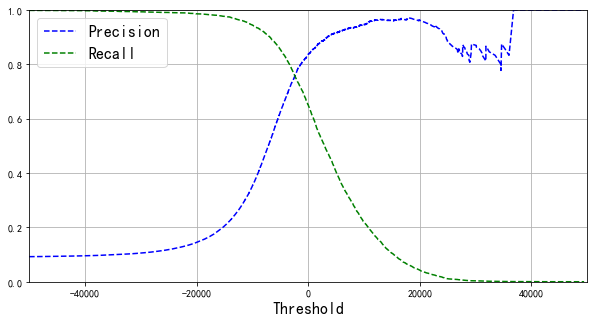

In [23]:
from sklearn.metrics import precision_recall_curve

# precision_recall_curve 计算所有可能阈值的精度和召回率
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# print(precisions.shape)
# print(recalls.shape)
# # 除了最后一个元素的切片
# print(precisions[:-1].shape)
# print(recalls[:-1].shape)
# print(thresholds.shape)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    # 精度相对于阈值
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    # 召回率相对于阈值
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.legend(fontsize=16)
    plt.xlabel("Threshold",fontsize=16)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])
    
plt.figure(figsize=(10,5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [24]:
(y_train_pred == (y_scores > 0)).all()

True

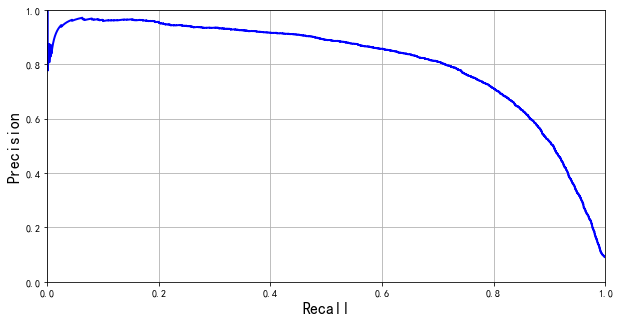

In [25]:
def plot_precision_vs_recall(precisions, recalls):
    # 召回率相对于精度
    plt.plot(recalls, precisions, "b-",linewidth=2)
    plt.xlabel("Recall",fontsize=16)
    plt.ylabel("Precision",fontsize=16)
    plt.axis([0,1,0,1])
    plt.grid(True)
 
plt.figure(figsize=(10,5))
plot_precision_vs_recall(precisions, recalls)
 
plt.show()

In [26]:
# 精度至少90% 的 最低阈值
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [27]:
# 所有样本 大于（精度至少90% 的 最低阈值） 分为正类
y_train_pred_90 = (y_scores >= threshold_90_precision)
# y_train_pred_90.shape

In [28]:
# 精度
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
# 召回率
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC曲线

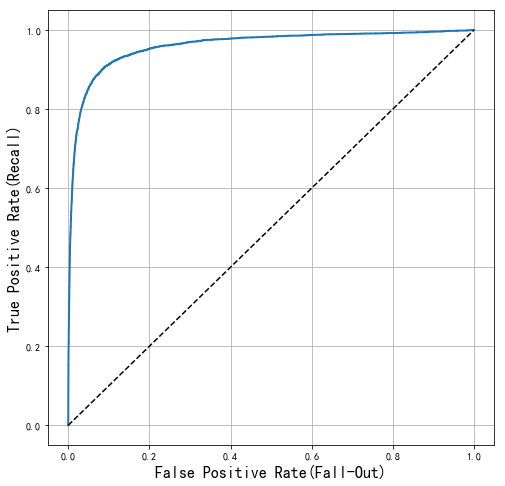

In [30]:
from sklearn.metrics import roc_curve

# roc_curve 计算所有可能阈值的 假正类率fpr 和 真正类率tpr
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate(Fall-Out)",fontsize=16)
    plt.ylabel("True Positive Rate(Recall)",fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8,8))
plot_roc_curve(fpr, tpr)
plt.show()

In [31]:
from sklearn.metrics import roc_auc_score

# roc_auc_score 测量曲线下面积 越接近于1越好
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

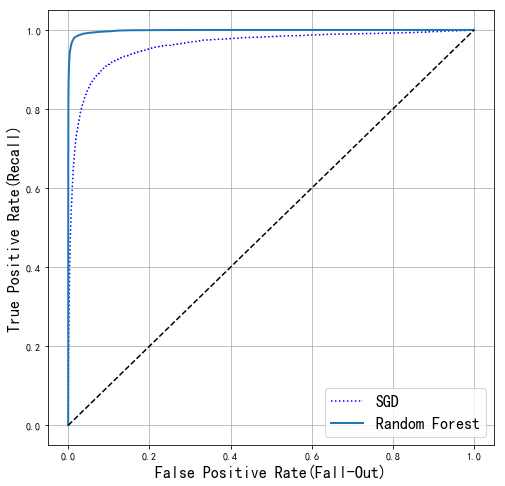

In [32]:
from sklearn.ensemble import RandomForestClassifier

# 随机森林分类器
forest_clf = RandomForestClassifier(random_state=42)

# cross_val_predict 使用 predict_proba 预测概率（cross_val_predict 使用 decision_function 预测分数）
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")
# print(y_probas_forest)
# print(y_probas_forest.shape)


y_scores_forest = y_probas_forest[:, 1] # [:, 0] 负类（非5） [:, 1] 正类（5）
# roc_curve 计算所有可能阈值的 假正类率fpr 和 真正类率tpr
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


plt.figure(figsize=(8,8))
# SGD ROC曲线
plt.plot(fpr, tpr, "b:", label="SGD")
# Random Forest ROC曲线
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.grid(True)
plt.legend(fontsize=16)
plt.show()

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 多类分类器

In [35]:
from sklearn.svm import SVC

# 创建SVM分类器（仅支持二分类）
svm_clf = SVC()
# 训练 多分类（自动监测选择 OvR or OvO：样本量大适合于后者 所以实际上训练了45个二分类器）
svm_clf.fit(X_train, y_train)
# 预测 多分类结果
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [36]:
# 用于预测的决策分数 每个类别一个分数
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [37]:
# 选出最高分数对应的类别
np.argmax(some_digit_scores)

5

In [38]:
# 目标类列表
svm_clf.classes_
# svm_clf.classes_[5]

5

In [39]:
from sklearn.multiclass import OneVsRestClassifier

# 创建OvR分类器
ovr_clf = OneVsRestClassifier(SVC())
# 训练（强制设定 OvR：实际上训练了10个二分类器）
ovr_clf.fit(X_train, y_train)
# 预测
ovr_clf.predict([some_digit])

KeyboardInterrupt: 

In [ ]:
# 用于预测的决策分数 每个类别一个分数
some_digit_scores = ovr_clf.decision_function([some_digit])
some_digit_scores

In [ ]:
# 选出最高分数对应的类别
np.argmax(some_digit_scores)

In [ ]:
# 目标类列表
ovr_clf.estimators_

In [ ]:
# 创建随机梯度下降分类器（可直接处理多分类）
# sgd_clf = SGDClassifier(random_state=42)
# 训练
sgd_clf.fit(X_train, y_train)
# 预测
sgd_clf.predict([some_digit])

In [ ]:
# 用于预测的决策分数 每个类别一个分数
sgd_clf.decision_function([some_digit])

In [ ]:
# 交叉验证评估准确率
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [40]:
from sklearn.preprocessing import StandardScaler

# 标准化缩放
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 误差分析

In [41]:
# 返回所有实例的预测结果
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
# 混淆矩阵
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

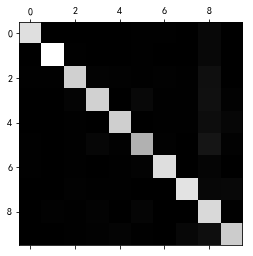

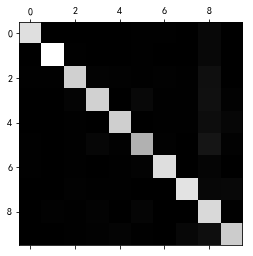

In [45]:
# 黑白可视化混淆矩阵 每行表示原始真正的类别 每列表示预测的类别 对角线位置越亮 表明正确分类的个数越多
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# 彩色可视化混淆矩阵
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
#     fig.colorbar(cax)
 
plot_confusion_matrix(conf_mx)
plt.show()

In [48]:
# 列向量（每行）求和
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)
# 错误绝对值 转为 占对应类的比率
norm_conf_mx = conf_mx / row_sums

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]


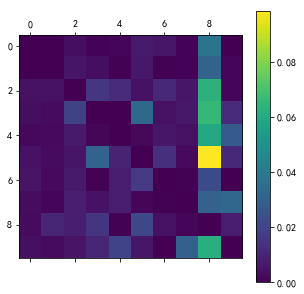

In [49]:
# 用0填充对角线 只保留错误
np.fill_diagonal(norm_conf_mx, 0)
# plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plot_confusion_matrix(norm_conf_mx)
plt.show()

In [71]:
# 定义显示图像函数：
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

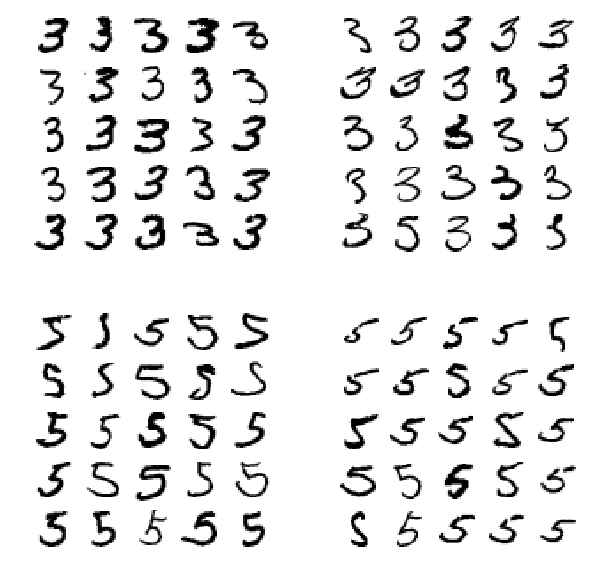

In [74]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(10,10))

plt.subplot(221); plot_digits(X_aa[:25],images_per_row=5); 
plt.subplot(222); plot_digits(X_ab[:25],images_per_row=5); 
plt.subplot(223); plot_digits(X_ba[:25],images_per_row=5); 
plt.subplot(224); plot_digits(X_bb[:25],images_per_row=5);
plt.show()

## 3.6 多标签分类

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# 大数标签
y_train_large = (y_train >= 7)
# 奇数标签
y_train_odd = (y_train % 2 == 1)
# 合并为多标签
y_multilabel = np.c_[y_train_large, y_train_odd]

# K近邻多标签分类器
knn_clf = KNeighborsClassifier()
# 训练
knn_clf.fit(X_train, y_multilabel)
# 预测
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# 返回所有实例的预测结果
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
# F1分数
f1_score(y_multilabel, y_train_knn_pred)

## 3.7 多输出分类

In [ ]:
# 原训练集输入+噪声
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100,(len(X_test), 784))
# 原测试集输入+噪声
X_test_mod = X_test + noise

# 训练集标签 = 原训练集输入
y_train_mod = X_train
# 测试集标签 = 原测试集输入
y_test_mod = X_test

# 窥探数据
some_index = 0
plt.subplot(1,2,1)
plot_digits([X_test_mod[some_index]])
plt.subplot(1,2,2)
plot_digits([y_test_mod[some_index]])
plt.show()

In [ ]:
# 训练 有噪声的训练集输入 以没有噪声的训练集输入作为标签
knn_clf.fit(X_train_mod, y_train_mod)
# 预测 有噪声的测试集输入 
clean_digit = knn_clf.predict([X_test_mod])
plot_digit(clean_digit)